# Electron lifetime analysis example

Jelle, January 2016

**Abstract**

I show how to extract an electron lifetime from pax-processed data using two methods:
  * An exponential fit to the mean S2 size in drift-time slices
  * An unbinned-likelihood inference

This example is simply an updated version of my [earlier analysis note](https://xecluster.lngs.infn.it/dokuwiki/lib/exe/fetch.php?media=xenon:xenon1t:aalbers:electron_lifetime_analysis_example.html).

In [1]:
# Boilerplate startup code
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('font', size=16)
plt.rcParams['figure.figsize'] = (12.0, 10.0)    # resize plots

from pax import units
import hax
hax.init()

hax.ipython.code_hider()

/home/jelle/anaconda3/envs/pax/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


# Table of Contents
 <p><div class="lev1"><a href="#Electron-lifetime-analysis-example-1">Electron lifetime analysis example</a></div><div class="lev2"><a href="#Data-selection-1.1">Data selection</a></div><div class="lev2"><a href="#Exploratory-analysis-1.2">Exploratory analysis</a></div><div class="lev2"><a href="#Fitting-drift-time-slices-1.3">Fitting drift time slices</a></div><div class="lev2"><a href="#Likelihood-analysis-1.4">Likelihood analysis</a></div><div class="lev2"><a href="#Outlook-1.5">Outlook</a></div><div class="lev1"><a href="#Appendix-2">Appendix</a></div><div class="lev2"><a href="#Drift-time-calculation-issue-2.1">Drift time calculation issue</a></div>

## Data selection

I will focus on a single dataset: xe100_111110_1127. The [XENON100 runs database](https://xecluster.lngs.infn.it/dokuwiki/doku.php?id=xenon:xenon100:runs&run_name=run_10&dataset=xe100_111110_1127#details) shows an electron lifetime of 82.70 ± 0.76 us.

Using `hax`, we can load a minitree containing the basic variables in the data set in one line (and ~30 seconds, or 0 if you've done it before or are using a cached version on your analysis factility):

`data = hax.minitrees.load('xe100_111110_1127')`

However, at the moment there is a problem with how pax computes drift time (see the appendix). Until this is fixed, we can re-compute the drift time from the lower-level information in the file:

In [8]:
#hax.runs.datasets.query('source == "Cs137" & location != ""').name.values

In [9]:
# I also load the S2 width, for use in the plot in the appendix
class NewDriftTime(hax.minitrees.TreeMaker):
    __version__ = '0.0.1'
    extra_branches = ['peaks.index_of_maximum', 'peaks.hit_time_std']
    
    def extract_data(self, event):
        if not len(event.interactions):
            return dict()
        s1 = event.peaks[event.interactions[0].s1]
        s2 = event.peaks[event.interactions[0].s2]
        return dict(drift_time_2=(s2.index_of_maximum - s1.index_of_maximum) * 10,
                    s2_width=s2.hit_time_std)

data = hax.minitrees.load('xe100_111110_1127', ['Basics', NewDriftTime])

Created minitree Basics for dataset xe100_111110_1127
Created minitree NewDriftTime for dataset xe100_111110_1127


`data` is now a pandas DataFrame containing basic info (see below) for all the events. For more details, and instructions on how to select your own variables, see the `hax` tutorial. Here is a look inside the data we just loaded:

In [10]:
data.head()

,index,cs1,cs2,dataset_number,drift_time,event_number,event_time,largest_coincidence,largest_other_s1,largest_other_s2,...,s1,s1_area_fraction_top,s2,s2_area_fraction_top,x,y,z,index,drift_time_2,s2_width
0,0,533.132248,117434.248258,1111101127,102700.195312,0,1320920877023216128,0,0,2401.281006,...,507.282318,0.139136,93471.437500,0.460508,-6.911321,11.892453,-17.767134,0,101100,4871.095703
1,1,NaN,NaN,1111101127,NaN,1,1320920877024649984,0,0,45.341877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
2,2,916.212603,89846.426385,1111101127,159293.125000,2,1320920877028420096,0,0,28.478455,...,1489.970215,0.060396,63061.921875,0.537962,-10.647170,1.930189,-27.557713,2,153220,7685.430176
3,3,NaN,NaN,1111101127,NaN,3,1320920877029669120,0,0,81.257607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN
4,4,337.785598,32902.233486,1111101127,160682.093750,4,1320920877032971008,0,0,851.586121,...,495.363617,0.069065,23022.435547,0.465001,-9.650944,6.786792,-27.798002,4,160160,1855.047974


As always, see the documentation for the Basics minitree [here](http://hax.readthedocs.org/en/latest/hax.treemakers.html#module-hax.treemakers.Basics) if you want to know what the variables here mean. Note event_time is messed up because this data was processed with a rather old pax version. drift_time_2 we just added ourselves. 

As you can see, there are no cuts applied: some events don't even have an s1 and an s2. We don't need very fine-tuned cuts for a decent analysis: the photopeak should be clear anyway:

  * The main S1 should be > 100 pe
  * The main S2 should be > 1000 pe
  * The next largest S2 should be < 100 pe (there is always one, due to single electron tails)
  * There should not be any other S1
  * There should be nothing (except perhaps lone hits) in the veto 

In [5]:
def do_cut(cut, name=''):
    """Does a cut, prints out acceptance info"""
    global data
    n_before = len(data)
    data = data[cut]
    print("%s cut: %d events removed (%0.2f%% passthrough)" % (
            name, n_before - len(data), len(data)/n_before * 100))

# Basic cuts
do_cut(data['s1'] > 100, 'S1 range')
do_cut(data['s2'] > 1000, 'S2 range')

# Double scatter cuts
do_cut(True ^ (data['largest_other_s2'] > 100), 'S2 double scatter')
do_cut(data['largest_other_s1'] == 0, 'S1 double scatter')
do_cut(data['largest_veto'] == 0, 'Veto')
print("%d events remaining" % len(data))

S1 range cut: 27847 events removed (44.31% passthrough)
S2 range cut: 122 events removed (99.45% passthrough)
S2 double scatter cut: 14963 events removed (32.08% passthrough)
S1 double scatter cut: 631 events removed (91.07% passthrough)
Veto cut: 1488 events removed (76.88% passthrough)
4949 events remaining


We'd like to have the drift time in us, and the S2 area on the bottom. Let's compute these from the basic variables:

In [12]:
drift_time = data['drift_time_2'].values / units.us
s2_bottom = data['s2'].values * (1 - data['s2_area_fraction_top'].values)

## Exploratory analysis

Before fitting, let's have a first look at the data we have:

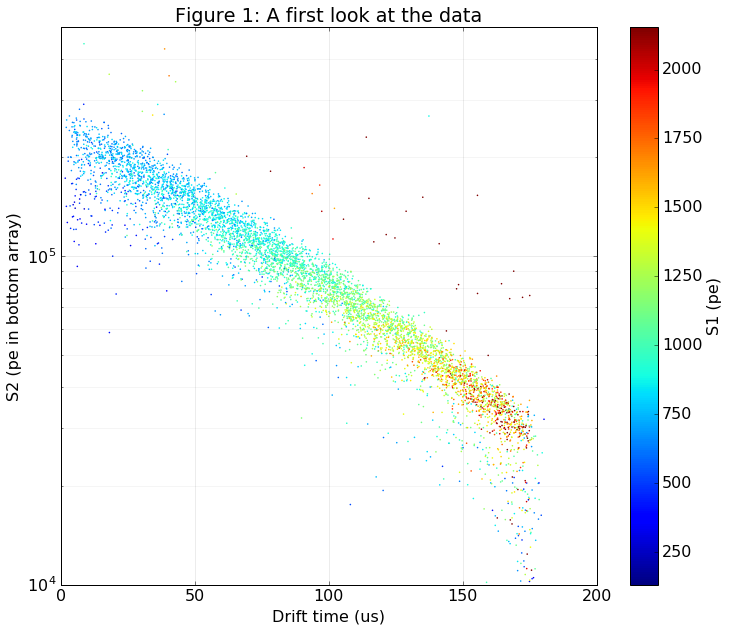

In [13]:
plt.scatter(drift_time, s2_bottom, 
            c=(data['s1'].values), vmax=2 * data['s1'].mean(),
            marker='.', edgecolors='none', s=10)
plt.yscale('log')
cb = plt.colorbar(label='S1 (pe)')
plt.grid(which='minor', linestyle='-', alpha=0.08)
plt.grid(which='major', linestyle='-', alpha=0.15)
plt.xlim(0, 200)
plt.ylim(1e4, 5e5)
plt.xlabel('Drift time (us)')
plt.ylabel('S2 (pe in bottom array)')
plt.title('Figure 1: A first look at the data')
plt.show()

We can clearly see the photopeak, as well as its exponential decrease with drift time. The Compton scatter events are  effectively removed by the applied double scatter cuts.

However, a few contaminating populations are present:
  * A population below the photopeak, particularly at low drift time;
  * Some unusually small S1s at high drift time;
  * A few stray events at high S2 -- these are probably unresolved double scatter events, as the S1 is also larger.

In a real analysis we should now investigate these populations (look at their waveforms) and cut them out.

## Fitting drift time slices

Here I make several drift time slices, then compute the mean S2 area for each slice. You could also compute the median, or even fit a Gaussian/Lorentzian/younameit to the slice instead.

For the error on each slice's mean, I use the standard error: $s/\sqrt{n}$ with s the sample standard deviation (of the S2s is the slice) and n the number of events in the slice.

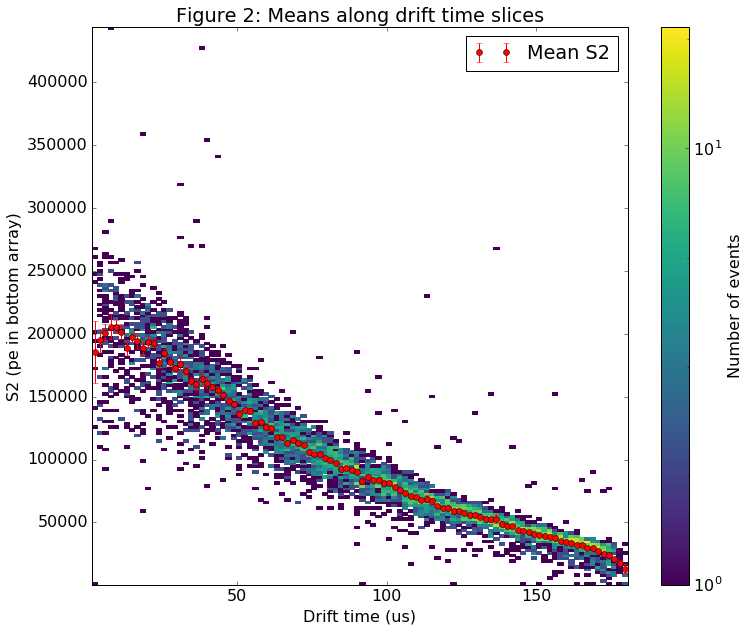

In [14]:
# There are many ways to do this...
# I'll make a s2 histogram using multihist.Histdd, then use its .average and .std methods
# If you don't like using custom packages such as multihist, 
# try pandas.groupby with the bin slices, then iterate over the slices. 
from multihist import Histdd
h = Histdd(drift_time, s2_bottom, bins=(100, 200),
           axis_names=['drift_time', 's2'])

t = h.bin_centers('drift_time')
y = h.average('s2').histogram
std_error = (h.std(axis='s2') / np.sqrt(h.sum('s2'))).histogram

h.plot(log_scale=True, cmap='viridis', cblabel='Number of events')
plt.errorbar(t, y, yerr=std_error,
             marker='o', linestyle='', color='red',
             label='Mean S2')
plt.xlabel('Drift time (us)')
plt.ylabel('S2 (pe in bottom array)')
plt.legend()
plt.title("Figure 2: Means along drift time slices")
plt.show()

Now we can fit the function $y = A * e^{-t/\tau}$ to each slice, where:
  * $y$ the mean S2 area in the drift timeslice
  * t the center of the drift time slice 
  * $\tau$ the electron lifetime and
  * $A$ a normalizing constant. 

I will try three fits: a normal fit, a sloppy fit which forgets about the error bars, and a fit constrained to the database electron lifetime value for this dataset (65 us).

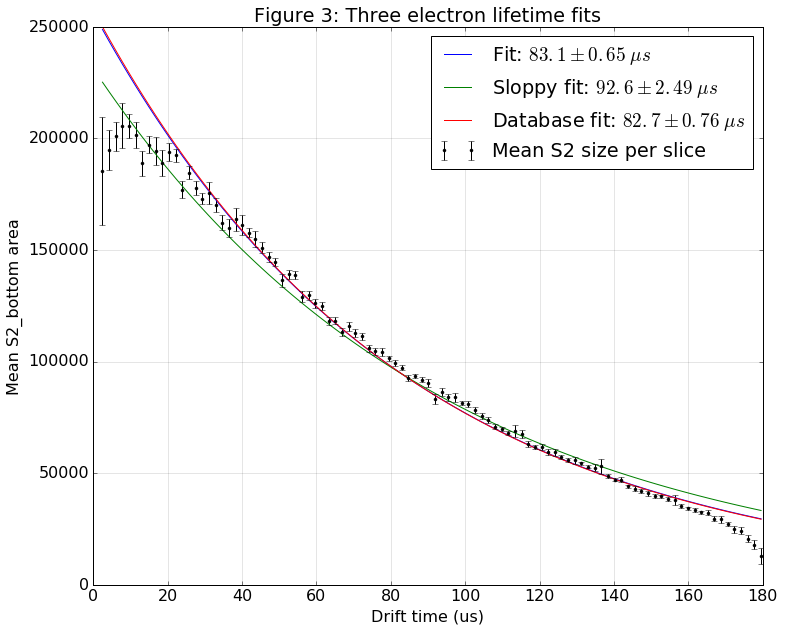

In [16]:
from scipy.optimize import curve_fit
def s2_area_f(t, tau, A):
    return A * np.exp(-t/tau)

# Free fit
(tau_fit, A_fit), cov = curve_fit(s2_area_f, t, y, sigma=std_error, p0=[100, 2 * y.mean()])
plt.plot(t, s2_area_f(t, tau_fit, A_fit), 
         label="Fit: $%0.1f \pm %0.2f \; \mu s$" % (tau_fit, cov[0][0]))

# Free fit, without taking errors on points into account
(tau_fit_sloppy, A_fit_sloppy), cov = curve_fit(s2_area_f, t, y, p0=[100, 2 * y.mean()])
plt.plot(t, s2_area_f(t, tau_fit_sloppy, A_fit_sloppy),  
         label="Sloppy fit: $%0.1f \pm %0.2f \; \mu s$" % (tau_fit_sloppy, cov[0][0]))

# Fit constrained to the XENON100 database lifetime
tau_db = 82.70
tau_db_cov = 0.76

(A_fit_db), cov = curve_fit(lambda t, A: s2_area_f(t, tau_db, A), 
                          t, y, sigma=std_error, p0=[2 * y.mean()])
plt.plot(t, s2_area_f(t, tau_db, A_fit_db), 
         label="Database fit: $%0.1f \pm %0.2f \; \mu s$" % (tau_db, tau_db_cov))

# Plot the data underneath
plt.errorbar(t, y, yerr=std_error,  
             linestyle='', marker='o', c='black', markersize=3,
             label="Mean S2 size per slice")
plt.legend()
plt.xlabel('Drift time (us)')
plt.ylabel('Mean S2_bottom area')
plt.grid(alpha=0.2, linestyle='-')
plt.ylim(0, 2.5e5)
plt.title("Figure 3: Three electron lifetime fits")
plt.show()

As you can see in figure 3, taking account of the errors helps us avoid pandering to the low-drifttime points, which have more contamination. We converge on a value very close to the database fit.

As usual in fits, the fit uncertainty should not be taken as estimating the total uncertainty on the value -- which is probably dominated by different effects, such as the contaminating populations and/or cuts used to remove them.

## Likelihood analysis

A different method, which avoids slicing, is to evaluate a likelihood for the entire data at once. We can then find the electron lifetime at the point of maximum likelihood and, if we want, we can quote a (Bayesian credibility) interval on it.

Here I assume the photopeak is a Lorentzian (Cauchy/Breit-Wigner), whose scale and location scale as $s(dt) = e^{-dt/\tau}$ with the drift time $dt$, where $\tau$ is the electron lifetime. A Gaussian would work too, of course, but it is more likely to be biased by outlying events. In reality a Gaussian or a convolution of Gaussian and Lorentzian (Voigt profile) might be best, but this model choice is beyond the scope of this note.

This means we use the likelihood function:

$L(\tau, \mu_0, \sigma_0) = \sum\limits^{\mathrm{events}} \mathrm{Lorentzian}(\mathrm{loc}=\mu_0 \cdot s(dt), \mathrm{scale} = \sigma_0  \cdot s(dt)).PDF(x)$

where $\mu_0$ and $\sigma_0$ are the photopeak mean size and width at 0 drift time, while $x$ and $dt$ are the S2 size and drift time of each event. Since we're not really interested in $\mu_0$ or $\sigma_0$, we can integrate the likelihood over them to obtain an estimate of $\tau$ and its uncertainty.



Here is the implementation of the log-likelihood function:

In [17]:
def lnprob(x):    
    # Unpack arguments, scale to proper size
    e_lifetime, zero_dt_mean, zero_dt_width = x
    zero_dt_mean *= 1e4
    zero_dt_width *= 1e4
    
    # "Priors" / range constraints
    if not 1 <= e_lifetime <= 1000:
        return -np.inf
    if not 0 <= zero_dt_mean <= 2e6:
        return -np.inf
    if not 0 <= zero_dt_width <= 1e5:
        return -np.inf
    
    # Progress bar hack, don't tell anyone you've read this...
    if lnprob.n_calls == 0:
        lnprob.t = tqdm(desc='Computing likelihoods', total=lnprob.total_calls)
    lnprob.n_calls += 1
    lnprob.t.update(1)
    
    # Compute mean and std of gaussian at each lifetime
    scaling = np.exp(-drift_time/e_lifetime)
    scaled_mean = zero_dt_mean * scaling
    scaled_std = zero_dt_width * scaling

    # Gaussian log likelihood (google if you don't believe me)
    # Vulnerable to outliers!
    # log_ls = -1/2 * (np.log(scaled_std**2 * 2* np.pi) + ((scaled_mean - s2_bottom)/scaled_std)**2)
    
    # Cauchy/Lorentz/Breit-Weigned log likelihood
    # Slight abuse of notation, using std in place of gamma
    log_ls = - np.log(scaled_std * np.pi) - np.log(1 + ((s2_bottom - scaled_mean)/scaled_std)**2)
    
    return log_ls.sum()

While we could sample the 3d parameter space $(\tau, \mu_0, \sigma_0)$ on a grid, this is very inefficient (most points will be far from the region of interest). We could run a minimizer, but that would only give us the minimum. The fancy solution is to use a Markov-chain Monte-Carlo which will take care of the sampling for us:

In [19]:
import emcee

guess = np.array([100, 30, 1])

n_walkers = 50
n_steps = 1000
n_params = len(guess)

# Progress bar hack part II -- you didn't see this, right?
lnprob.total_calls = n_walkers * n_steps
lnprob.n_calls = 0

# Start walkers in ball around guess
p0 = np.array([2 * np.random.rand(n_params) * guess for i in range(n_walkers)])

# Run sampler
sampler = emcee.EnsembleSampler(n_walkers, n_params, lnprob)
sampler.run_mcmc(p0, n_steps)

# Remove first 50 samples for each walker (burn-in)
samples = sampler.chain.ravel()
samples = sampler.chain[:, 50:, :].reshape((-1, n_params))

Computing likelihoods:  97%|█████████▋| 48659/50000 [00:35<00:00, 1425.09it/s]

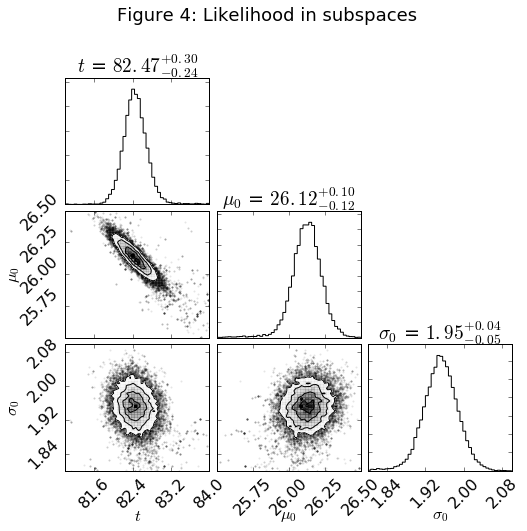

In [24]:
import corner
labels = ['$t$', '$\mu_0$', '$\sigma_0$']

corner.corner(samples,  labels=labels, bins=50,
              show_titles=True, #plot_contours=False,
              range=((81, 84), (25.5, 26.5), (1.8, 2.1))    # Use range=0.95 or leave out if you don't know these
             )
plt.suptitle("Figure 4: Likelihood in subspaces", fontsize=18)
plt.subplots_adjust(top=0.85)
plt.show()

Figure 4 qualitatively shows the marginalized likelihood in every 1- and 2- dimensional subspace of our parameter space (marginalized = integrated over the dimensions not shown). Sorry for the labels in figure, I'm still fighting with the `corner` package a bit:
  * Somehow the $\tau$ label doesn't work, so I've put $t$ instead.
  * $t$ is in us as a bove, $\mu_0$ and $\sigma_0$ in 1e4 pe.

The result is very similar to the slice fit. In case you want the actual values:

In [25]:
# From http://dan.iel.fm/emcee/current/user/line/
samples2 = np.copy(samples)
samples2[:, 2] = np.exp(samples2[:, 2])
result = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                  zip(*np.percentile(samples2, [16, 50, 84], axis=0))))
result[0]

(82.469972467375271, 0.29626598082965927, 0.2385353224500335)

## Outlook


  * Two electron lifetime determination procedures (slices, likelihood) give similar results;
  * Contaminating populations, such as the one at low drift times, can affect the result and should be investigated;
  * The uncertainty is probably dominated by systematics due to contamination and/or cut acceptance effects.

# Appendix 

## Drift time calculation issue

MarcS correctly pointed out some events were missing at low drift times in the previous version of this note. This is due to a problem with pax, or rather an interaction of two problems: 
  * a clustering issue at very high S2 in very impure data (see [Github issue 225](https://github.com/XENON1T/pax/issues/225), also has an example waveform) and 
  * the way we define drift time.

**Clustering issue:** At ultra-high energy in very impure data, the single electron tail after the S2 is very strong. Currently (but only under these specific conditions) some 20-50 us of this tail doesn't get split off from the S2, causing completely unrealistic S2 widths:

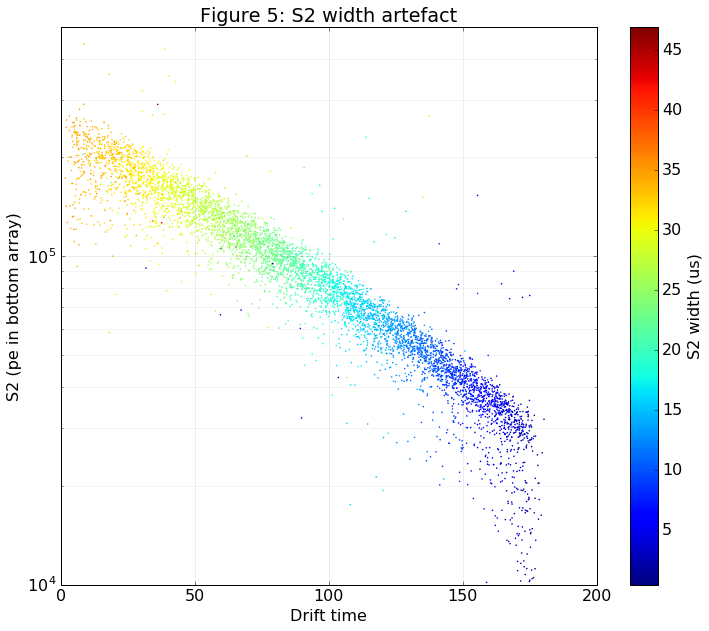

In [26]:
s2_width = data['s2_width'].values / units.us
plt.scatter(drift_time, s2_bottom, 
            c=s2_width, # vmax=2 * s2_width.mean(),
            marker='.', edgecolors='none', s=10)
plt.yscale('log')
cb = plt.colorbar(label='S2 width (us)')
plt.grid(which='minor', linestyle='-', alpha=0.08)
plt.grid(which='major', linestyle='-', alpha=0.15)
plt.xlim(0, 200)
plt.ylim(1e4, 5e5)
plt.xlabel('Drift time')
plt.ylabel('S2 (pe in bottom array)')
plt.title('Figure 5: S2 width artefact')
plt.show()

(the S2 width in figure 5 is the weighted standard deviation of the hit times, practically very similar to the rms of the peak's sum waveform. We have several other S2 width variables in pax, some of which (such as range_area_decile[5]) should be  more robust to these effects, but not enough to eliminate it)

**Drift time computation:** We use the center of gravity of the S2 to compute the drift time. At low energy this is more robust than using e.g. the maximum amplitude point or the left edge (even though it is inevitably, though slightly, biased). However, the "sticky tail" messes things up: although the tail is quite tiny (and should have little effect on the overall area), it has a long lever arm. Hence the drift time is biased severely to the right. 

This explains why there were initially no events below ~20 us in figure 1. I've repaired the situation by re-computing the drift time as the time between the maxima of the S1 and S2. We should investigate which drift time method is the best at low- and high energy, and of course the 'sticky tails' problem should be addressed. We could cut off the S2 arbitrarily at (e.g. 1% height like Xerawdp), but ideally the clustering should just be improved to handle it properly.